In [1]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import gmean, linregress
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, MultipleLocator
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
# Import dataframes
fits = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\2nd_order\deckagol_TTVFast_fits.csv")
fits.head()

,e1,w1,e2,w2,Delta,j,N,P1,P2,mu1,...,phase1,std1,A2,B2,V2,Pttv2,phase2,std2,R2_1,R2_2
0,0.007380,324.612682,0.007380,324.612682,-0.004655,5,2,30,49.767240,0.00001,...,6.017048,0.000746,0.032766,-4.888214e-05,0.171238,21876.230874,6.090359,0.000712,0.006857,0.011394
1,0.030366,87.858502,0.030366,267.858502,-0.009659,5,2,30,49.517031,0.00001,...,2.536053,0.004303,0.001056,-8.205480e-07,0.008961,1047.864761,5.628309,0.006179,0.959770,0.969121
2,0.001313,27.412969,0.001313,27.412969,-0.003028,5,2,30,49.848618,0.00001,...,6.393856,0.000787,-0.006181,-7.546527e-06,0.036926,28883.964329,6.447432,0.000764,0.004168,0.005261
3,0.075404,82.673787,0.075404,82.673787,0.001778,5,2,30,50.088879,0.00001,...,2.921880,0.001042,0.654530,-6.932827e-04,2.771991,25008.344610,6.045786,0.001114,0.368095,0.460295
4,0.015761,261.026633,0.015761,81.026633,0.006085,5,2,30,50.304259,0.00001,...,2.662700,0.002068,-0.006806,9.329151e-06,0.006680,1757.656951,6.238018,0.002687,0.871939,0.933145


In [3]:
# Compare error relative to solution similar to figure 2
# Code of course copypasted from 1st order TTVfast validation
valid = fits['valid']
j = fits['j']; N = fits['N']
mmr = j.apply(lambda x: f"{int(x)}:{int(x)-2}")
mu_in = fits['mu1']; mu_out = fits['mu2']
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = np.abs(fits['Pttv1']); PTTV_out = np.abs(fits['Pttv2'])
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities(e1[i], w1[i], e2[i], w2[i]) for i in range(len(e1))]
Mstar = 1

# Extract mu_in and mu_out
mu_calc_in, mu_calc_out = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    if valid[i] == False:  # If invalid column
        mu_calc_in = np.append(mu_calc_in, np.nan)
        mu_calc_out = np.append(mu_calc_out, np.nan)
        continue

    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    # If NOT include first-order term
    mu_code_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i], inner_period=P_in[i])
    mu_code_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i], outer_period=P_out[i])

    mu_calc_in = np.append(mu_calc_in, mu_code_in)
    mu_calc_out = np.append(mu_calc_out, mu_code_out)

compare = fits.copy()
compare['mu_calc_in'] = mu_calc_in
compare['mu_calc_out'] = mu_calc_out
compare.head()

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 383.78it/s]


,e1,w1,e2,w2,Delta,j,N,P1,P2,mu1,...,A2,B2,V2,Pttv2,phase2,std2,R2_1,R2_2,mu_calc_in,mu_calc_out
0,0.007380,324.612682,0.007380,324.612682,-0.004655,5,2,30,49.767240,0.00001,...,0.032766,-4.888214e-05,0.171238,21876.230874,6.090359,0.000712,0.006857,0.011394,NaN,NaN
1,0.030366,87.858502,0.030366,267.858502,-0.009659,5,2,30,49.517031,0.00001,...,0.001056,-8.205480e-07,0.008961,1047.864761,5.628309,0.006179,0.959770,0.969121,0.000010,0.000010
2,0.001313,27.412969,0.001313,27.412969,-0.003028,5,2,30,49.848618,0.00001,...,-0.006181,-7.546527e-06,0.036926,28883.964329,6.447432,0.000764,0.004168,0.005261,0.009263,0.018543
3,0.075404,82.673787,0.075404,82.673787,0.001778,5,2,30,50.088879,0.00001,...,0.654530,-6.932827e-04,2.771991,25008.344610,6.045786,0.001114,0.368095,0.460295,NaN,NaN
4,0.015761,261.026633,0.015761,81.026633,0.006085,5,2,30,50.304259,0.00001,...,-0.006806,9.329151e-06,0.006680,1757.656951,6.238018,0.002687,0.871939,0.933145,NaN,NaN


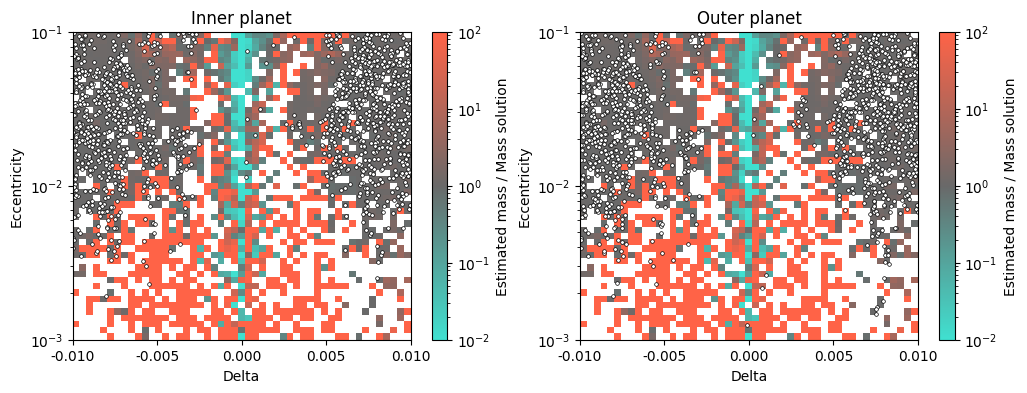

In [4]:
# Recreate figure 2
Delta = compare['Delta']
e1 = compare['e1']; e2 = compare['e2']
err1 = compare['mu_calc_in'] / compare['mu1']
err2 = compare['mu_calc_out'] / compare['mu2']

errtol = 1.1
err1_10p = (err1 <= errtol) & (err1 >= 1/errtol)
err2_10p = (err2 <= errtol) & (err2 >= 1/errtol)

# Set up grid image
xbins = np.linspace(-0.01, 0.01, 50)
ybins = 10**np.linspace(-3, -1, 50)
# Digitize points into bins (i.e. map Delta = 0 to bin 50/100)
xi = np.digitize(Delta, xbins) - 1
yi = np.digitize(e1, ybins) - 1
Z1 = Z2 = np.full((len(ybins)-1, len(xbins)-1), np.nan) # Initialize array for medians

# Compute median in each bin
for i in range(len(xbins)-1):
    for j in range(len(ybins)-1):
        mask = (xi == i) & (yi == j)
        err1values = err1[mask]
        err2values = err2[mask]
        Z1[j,i] = np.nanmedian(err1[mask]) if np.any(~np.isnan(err1values)) else np.nan
        Z2[j,i] = np.nanmedian(err2[mask]) if np.any(~np.isnan(err2values)) else np.nan

# Plot
fig, ax =  plt.subplots(1, 2, figsize=(12,4))
cmap = mcolors.LinearSegmentedColormap.from_list('custom', ['turquoise', 'dimgray', 'tomato'])
norm = mcolors.LogNorm(1e-2, 1e+2)

im0 = ax[0].pcolormesh(xbins, ybins, Z1, norm=norm, cmap=cmap, shading='auto')
sc0 = ax[0].scatter(Delta[err1_10p], e1[err1_10p], s=7, facecolor='white', edgecolor='black', linewidth=0.5, marker='o')
plt.colorbar(im0, ax=ax[0], label='Estimated mass / Mass solution')
ax[0].set_title('Inner planet')

im1 = ax[1].pcolormesh(xbins, ybins, Z2, norm=norm, cmap=cmap, shading='auto')
sc1 = ax[1].scatter(Delta[err2_10p], e1[err2_10p], s=7, facecolor='white', edgecolor='black', linewidth=0.5, marker='o')
plt.colorbar(im1, ax=ax[1], label='Estimated mass / Mass solution')
ax[1].set_title('Outer planet')

for i, a in enumerate(ax):
    a.set_yscale('log')
    a.set_xlabel('Delta'); a.set_ylabel('Eccentricity')
    a.set_xlim(-0.01, 0.01); a.set_ylim(1e-3, 1e-1)
    a.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    a.xaxis.set_major_locator(MultipleLocator(0.005))

plt.show()

In [5]:
# Export results
compare.to_csv("deckagol_TTVFast_outputs.csv", index=False)